In [ ]:
%load_ext autoreload
%autoreload 2

In [27]:
import dotenv
import matplotlib.pyplot as plt
import numpy as np
from fl_g13.fl_pytorch.editing import load_mask
from fl_g13.editing import mask_dict_to_list, compute_mask_stats, print_mask_stats

In [28]:
dotenv.load_dotenv()
CHECKPOINT_DIR = dotenv.dotenv_values()["CHECKPOINT_DIR"]

In [29]:
union_mask_file_name =  CHECKPOINT_DIR + f"union_1_8_global_0.7_3.pth"

union_mask = load_mask(union_mask_file_name)

In [30]:
intersection_mask_file_name =  CHECKPOINT_DIR + f"intersection_1_8_global_0.7_3.pth"

intersection_mask = load_mask(intersection_mask_file_name)

In [31]:
union_stats = compute_mask_stats(union_mask)
intersection_stats = compute_mask_stats(intersection_mask)

In [32]:
# Aggregate by block for intersection
intersection_by_block = {}
missing_intersection = []

for layer, stats in intersection_stats.items():
    if layer == 'overall':
        if 'total_elements' not in stats or 'kept_elements' not in stats:
            missing_intersection.append(layer)
            continue
        block = 'overall'
        if block not in intersection_by_block:
            intersection_by_block[block] = {'block_num_elements': 0, 'block_kept_elements': 0}
        intersection_by_block[block]['block_num_elements'] = stats['total_elements']
        intersection_by_block[block]['block_kept_elements'] = stats['kept_elements']
    else:
        if 'num_elements' not in stats or 'kept_elements' not in stats:
            missing_intersection.append(layer)
            continue
        block = '.'.join(layer.split('.')[:3])
        if block not in intersection_by_block:
            intersection_by_block[block] = {'block_num_elements': 0, 'block_kept_elements': 0}
        intersection_by_block[block]['block_num_elements'] += stats['num_elements']
        intersection_by_block[block]['block_kept_elements'] += stats['kept_elements']

# Compute density
for block, st in intersection_by_block.items():
    total = st['block_num_elements']
    kept = st['block_kept_elements']
    st['density'] = kept / total if total > 0 else 0

if missing_intersection:
    print(f"Warning: skipped {len(missing_intersection)} layers without expected fields")

In [33]:
# Aggregate by block for union
union_by_block = {}
missing_union = []

for layer, stats in union_stats.items():
    if layer == 'overall':
        if 'total_elements' not in stats or 'kept_elements' not in stats:
            missing_union.append(layer)
            continue
        block = 'overall'
        if block not in union_by_block:
            union_by_block[block] = {'block_num_elements': 0, 'block_kept_elements': 0}
        union_by_block[block]['block_num_elements'] = stats['total_elements']
        union_by_block[block]['block_kept_elements'] = stats['kept_elements']
    else:
        if 'num_elements' not in stats or 'kept_elements' not in stats:
            missing_union.append(layer)
            continue
        block = '.'.join(layer.split('.')[:3])
        if block not in union_by_block:
            union_by_block[block] = {'block_num_elements': 0, 'block_kept_elements': 0}
        union_by_block[block]['block_num_elements'] += stats['num_elements']
        union_by_block[block]['block_kept_elements'] += stats['kept_elements']

# Compute density
for block, st in union_by_block.items():
    total = st['block_num_elements']
    kept = st['block_kept_elements']
    st['density'] = kept / total if total > 0 else 0

if missing_union:
    print(f"Warning: skipped {len(missing_union)} layers without expected fields")


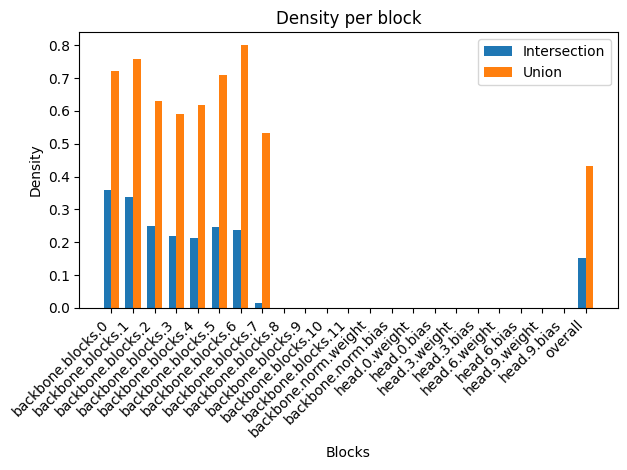

/Users/stefano_gamba/miniconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [34]:
# Preserve original insertion order of blocks
blocks = list(intersection_by_block.keys())
densities_intersection = [intersection_by_block[blk]['density'] for blk in blocks]
densities_union = [union_by_block.get(blk, {}).get('density', 0) for blk in blocks]

# Plot
x = np.arange(len(blocks))
width = 0.35

plt.figure()
plt.bar(x - width/2, densities_intersection, width, label='Intersection')
plt.bar(x + width/2, densities_union, width, label='Union')
plt.xlabel('Blocks')
plt.ylabel('Density')
plt.title('Density per block')
plt.xticks(x, blocks, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()